In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from utils import plot_images_full, generate_matrix, batch_dirichlet, get_similarities, plot_similarities, get_differences, plot_differences, get_images, plot_images

#from models.vit import ViT, SimpleViT, SimpleViTI, SimpleViTFT
from models.diffusion import SimpleTransformer

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def is_pos_def(M):
    return np.all(np.linalg.eigvals(M+M.T) > 0)

In [3]:
batch_size = 1
device = 'cpu'
data_path = './data/'

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                       download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

criterion = torch.nn.CrossEntropyLoss()

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def eval_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = val_acc = 0.0
    for (img, labels) in val_loader:
        img, labels = img.to(device), labels.to(device)
        with torch.no_grad():
            predictions = model(img)
            loss = criterion(predictions, labels)
            correct = torch.argmax(predictions.data, 1) == labels
        val_loss += loss
        val_acc += correct.sum()
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
        
    print(f" Test acc {val_acc:.3f}, Test loss {val_loss:.6f}")

In [6]:
depth=64
def get_model(m,s,wn,t,ws,acc,load=True):
    model = SimpleTransformer((3,32,32), 2, depth, 
        dim=128, 
        heads=1,
        num_classes=10, 
        sign=s, 
        tau=t, 
        embed=True,
        softw=False,
        weight_sharing=ws, 
        method=m,
        norm=True,
        weight_norm=wn,
        attn_norm=False
    )
    if load: model.load_state_dict(torch.load(f"model_method_{m}_sign_{s}_tau_{t}_wn_{wn}_ws_{ws}_idn_False_acc_{acc}.pth"))
    return model

In [7]:
image = testset[100][0].to(device).unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


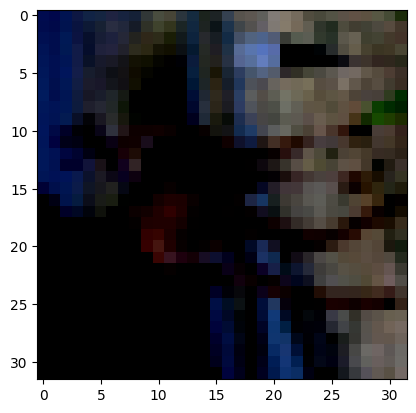

In [8]:
plt.imshow(image[0,...].transpose(-1,0))

## $\mathbf{F}(t+1) = \tau \mathbf{A}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + \mathbf{F}(t)$

In [9]:
model = get_model(m='D',s=0,wn=False,t=1,ws=False,acc=50,load=True).to(device)

In [10]:
#model.attn_norm = True
#model.weight_norm = True

In [11]:
outputs, attentions, Ws = model.diffuse(image)

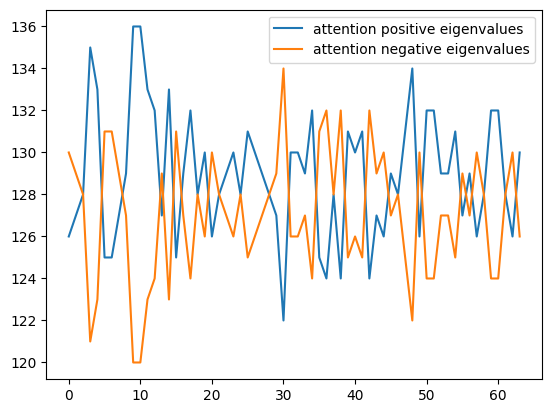

In [12]:
poseigs,negeigs=[],[]
for A in attentions:
    cpos,cneg=0,0
    for eig in np.linalg.eig(A[0,...])[0]:
        if eig>=0:
            cpos+=1
        else:
            cneg+=1
    poseigs.append(cpos)
    negeigs.append(cneg)
    
plt.plot(poseigs,label="attention positive eigenvalues")
plt.plot(negeigs,label="attention negative eigenvalues")
plt.legend()
plt.show()

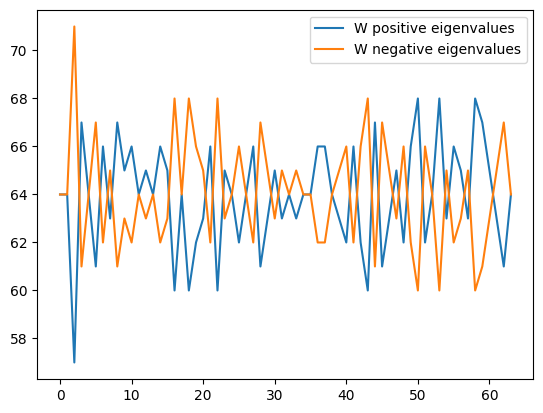

In [13]:
poseigs,negeigs=[],[]
for W in Ws:
    cpos,cneg=0,0
    for eig in np.linalg.eig(W.cpu().detach().numpy())[0]:
        if eig>=0:
            cpos+=1
        else:
            cneg+=1
    poseigs.append(cpos)
    negeigs.append(cneg)
    
plt.plot(poseigs,label="W positive eigenvalues")
plt.plot(negeigs,label="W negative eigenvalues")
plt.legend()
plt.show()

In [14]:
# idx=0
# one=torch.kron(Ws[idx],torch.from_numpy(attentions[idx][0,...]).to(device))
# Q=one+torch.eye(one.size(-1))
# is_pos_def((Q.T@Q-torch.eye(Q.size(-1))).cpu().detach().numpy())

In [15]:
# is_pos_def((Q.T@Q-torch.eye(Q.size(-1))).cpu().detach().numpy())

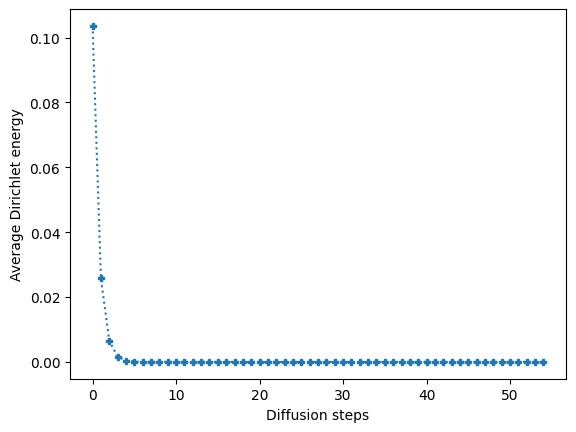

In [20]:
dirichlet_input = [x/(np.linalg.norm(x, ord='fro', axis=(-1,-2))) for x in outputs]
#dirichlet_input = [x for x in outputs]
similarities = get_similarities(dirichlet_input)
plot_similarities(similarities[10:])

In [33]:
np.linalg.norm(outputs[2])

227.92006

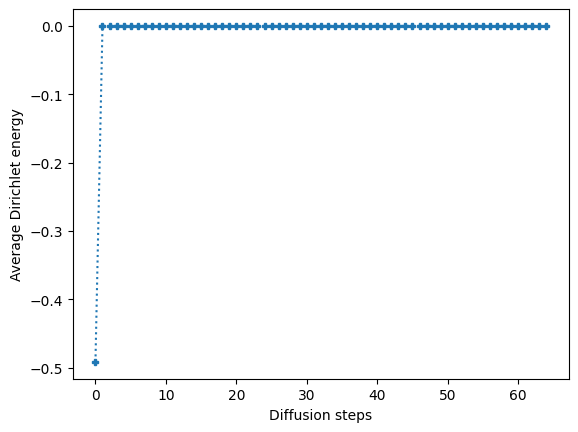

In [17]:
plot_similarities([-abs(x.sum(axis=(-1,-2)).mean()) for x in dirichlet_input])

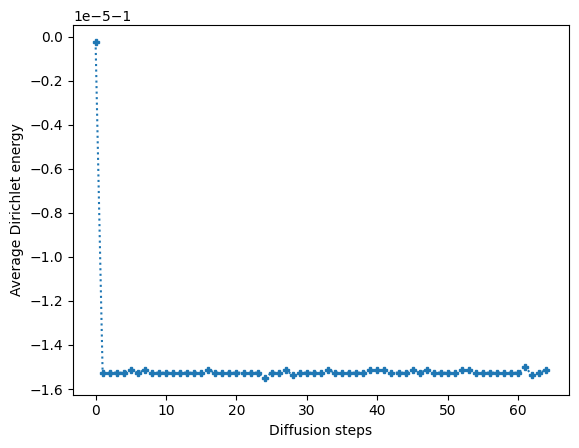

In [18]:
plot_similarities([-np.linalg.norm(x-(1/(x.shape[-1]*x.shape[-2]))) for x in dirichlet_input])

In [19]:
similarities[-2],similarities[-1]

(1.5423359000822493e-12, 1.9504010985617196e-12)

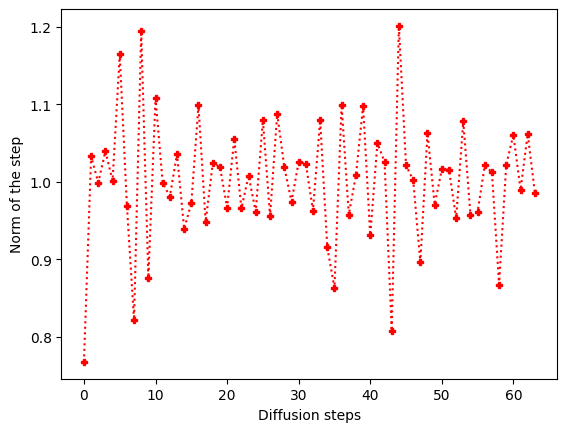

In [88]:
differences = get_differences(outputs)
plot_differences(differences)

In [92]:
differences[-1]

0.9859814007391863

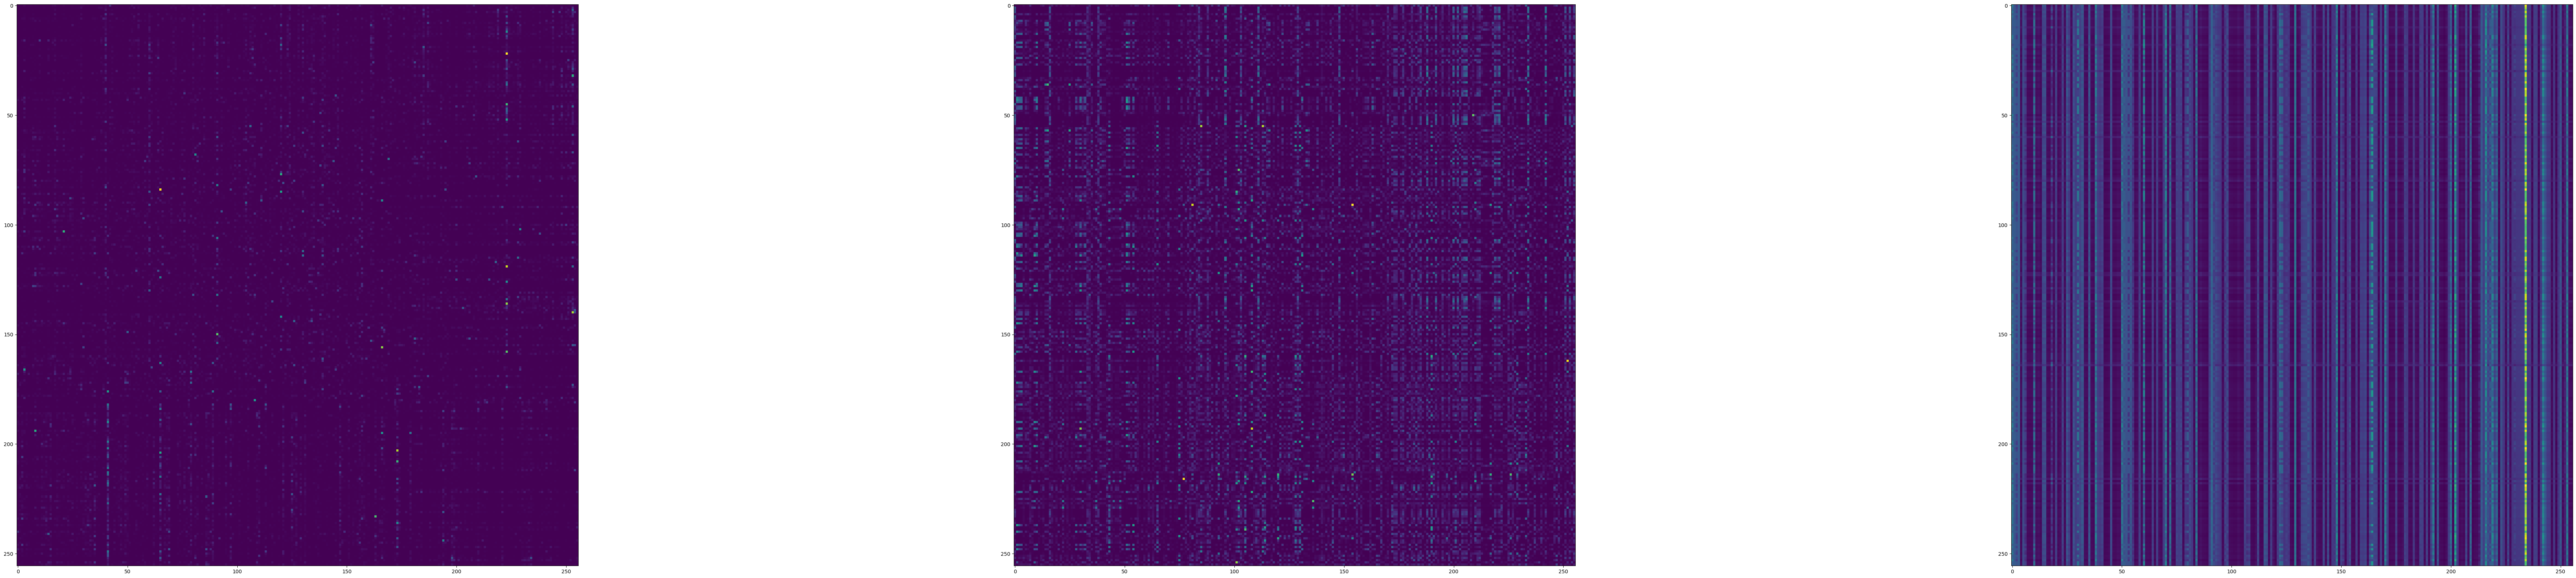

In [93]:
plot_images_full([attentions[0],attentions[30],attentions[-1]])

In [91]:
eval_model(model, val_loader, criterion, device)

 Test acc 0.106, Test loss 0.074798


In [106]:
model.depth = 32
model.tau = 0.5

In [104]:
eval_model(model, val_loader, criterion, device)

 Test acc 0.337, Test loss 0.054637


In [107]:
model.depth = 32
model.tau = (depth*model.tau)/model.depth
model.tau

1.0

In [98]:
eval_model(model, val_loader, criterion, device)

 Test acc 0.115, Test loss 0.138448
